In [1]:
data_dir = "D:\\data science\\kaggle\\store item demand"
work_dir = 'D:\\data science\\side projects\\Causal Inferences'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime as dt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'xtick.color':'black', 
          'ytick.color':'black', 
          'axes.titlesize':'25',
          'axes.labelsize': 'x-large',
          'figure.facecolor':'white'}
pylab.rcParams.update(params)

In [4]:
os.chdir(work_dir)

In [5]:
rng = np.random.RandomState(321)

In [6]:
raw_df = pd.read_pickle(data_dir+"\\train.pickle")

In [7]:
# scale up sales
raw_df['sales'] = raw_df['sales'] * 100

In [8]:
raw_df['year'] = pd.DatetimeIndex(raw_df.date).year
raw_df['month'] = pd.DatetimeIndex(raw_df.date).month

In [9]:
m_1 = raw_df['item']== 1
m_2 = raw_df['year'] == 2016

df = raw_df[m_1 & m_2]

df.date = pd.to_datetime(df.date.copy())
df.index = df.date
df = df.drop('date', axis = 1)

#sales of the target store (7th)
m = df['store'] == 7
t_df = df[m]

C:\Users\aoc32\anaconda3\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
#Simulated sales shock
mu = t_df[t_df['month'] == 5]['sales'].mean()
sigma = (t_df[t_df['month'] == 5]['sales'].std())

print(f'mu = {mu}, sigma = {sigma}')

mu = 1800.0, sigma = 475.3945729601885


In [11]:
#add the increasing sales to the original amount.
p_shock = rng.normal(mu, sigma, 31)
p_shock_sales = pd.DataFrame(p_shock, index = t_df[t_df['month'] == 5].index, columns = ['sales']).sales

In [12]:
#target df after shocked
s_t_df = t_df.sales.add(p_shock_sales, fill_value = 0)

In [13]:
m = t_df['month']<=5

<function matplotlib.pyplot.show(close=None, block=None)>

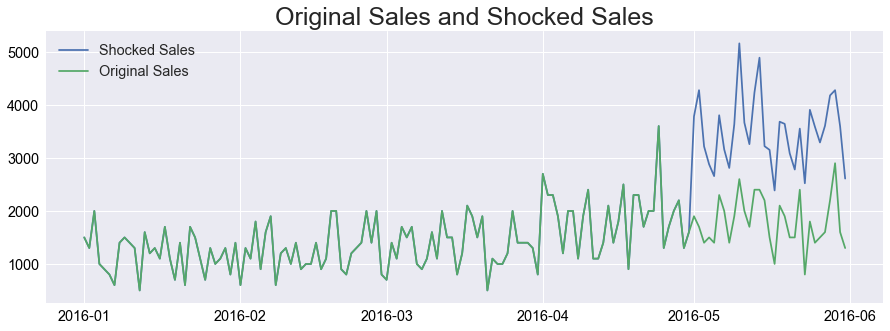

In [14]:
plt.plot(s_t_df[m])
plt.plot(t_df.sales[m])

plt.legend(['Shocked Sales', 'Original Sales'])
plt.title('Original Sales and Shocked Sales')
plt.show

In [15]:
df = df.copy()[df['store'] != 7]

In [16]:
s_t_df = pd.DataFrame(s_t_df)
s_t_df['store'] = 7
s_t_df['item'] = 1

In [17]:
s_t_df = s_t_df.reset_index()

In [18]:
s_t_df['year'] = pd.DatetimeIndex(s_t_df.date).year
s_t_df['month'] = pd.DatetimeIndex(s_t_df.date).month

In [19]:
s_t_df.index = s_t_df.date
s_t_df = s_t_df.drop('date', axis = 1)

In [20]:
df = pd.concat([df, s_t_df])

In [21]:
df = df[df.month <= 5]

In [22]:
def get_target_dataset(df, target_store):
    #Target store original sales
    t_df = df[df['store'] == target_store]
    
    #The sales of the other stores
    df_wide = pd.pivot(df.drop(['year','month'], axis = 1),
                       values = 'sales',
                       columns = 'store')

    #other sales df
    o_df = df_wide.copy().drop(columns = [target_store]) 
    
    return t_df, o_df

In [23]:
def period_mask(df, time_begin, time_ended):
    train_mask = df.reset_index().date < pd.Timestamp(time_begin)

    test_mask = (df.reset_index().date >= pd.Timestamp(time_begin)) \
                & (df.reset_index().date < pd.Timestamp(time_ended))
    return train_mask, test_mask

In [24]:
def train_test_split(t_df, o_df, time_begin, time_ended):
    # Construct X_train, y_train, X_test, y_test
    
    # X_train: Sales of the other store before May
    # y_train: Sales of the target store before May
    # X_test: Sales of the other store in May
    # y_test: Sales of the target store in May
    
    #get masks
    train_mask, test_mask = period_mask(df = t_df, time_begin = time_begin, time_ended = time_ended)    
    
    X_train = o_df.reset_index()[train_mask].drop('date', axis = 1)
    y_train = t_df.reset_index()[train_mask]['sales']

    X_test = o_df.reset_index()[test_mask].drop('date', axis = 1)
    y_test = t_df.reset_index()[test_mask]['sales']
    
    train_date = o_df.reset_index().loc[train_mask,'date']
    test_date = t_df.reset_index().loc[test_mask,'date']
    
    train_test_date =  {'X_train':X_train,
                        'y_train':y_train, 
                        'X_test':X_test, 
                        'y_test':y_test, 
                        'train_date':train_date, 
                        'test_date':test_date}
    return train_test_date

In [25]:
def fit_model(train_test_date):
    from sklearn.linear_model import LinearRegression
    
    X_train = train_test_date['X_train']
    y_train = train_test_date['y_train']
    X_test = train_test_date['X_test']
    y_test = train_test_date['y_test']
    train_date = train_test_date['train_date']
    test_date = train_test_date['test_date']
    
    #fit model
    model = LinearRegression()
    model.fit(X_train, y_train)

    #contruct synthetic y(sales)
    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)

    #date
    date = train_date.append(test_date)

    #previous sales + synthetic sales
    syn_sales = pd.Series(y_train_hat).append(pd.Series(y_test_hat)).reset_index(drop = True)

    #orginal sales data of the target store
    real_sales = y_train.append(y_test)
    
    synthetic = {
        'date':date,
        'syn_sales':syn_sales,
        'real_sales':real_sales,
        'model':model
    }
    
    return synthetic

In [26]:
target_store = 7
t_df, o_df = get_target_dataset(df, target_store = target_store)

time_begin = '2016-05-01'
time_ended = '2016-06-01'

train_test_date = train_test_split(t_df = t_df,
                                   o_df = o_df, 
                                   time_begin = time_begin, 
                                   time_ended = time_ended)

synthetic = fit_model(train_test_date)

In [27]:
date = synthetic['date']
syn_sales = synthetic['syn_sales']
real_sales = synthetic['real_sales']

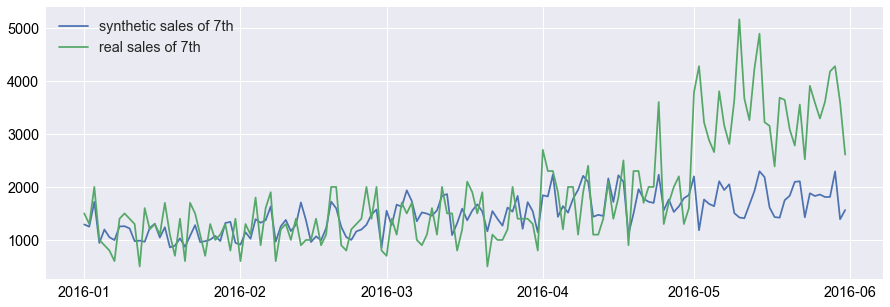

In [28]:
plt.plot(date,syn_sales)
plt.plot(date,real_sales)

plt.legend(['synthetic sales of 7th', f'real sales of 7th'])

In [29]:
est_dyn_effect = real_sales - syn_sales

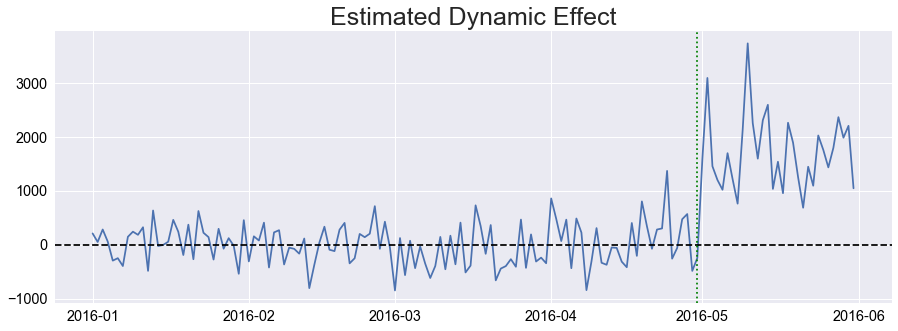

In [30]:
plt.plot(date, est_dyn_effect)
plt.title('Estimated Dynamic Effect')
plt.axhline(0, color = 'black', linestyle = '--')
plt.axvline(pd.Timestamp('2016-04-30'), color = 'green', linestyle = ':')

In [31]:
def SC_dynamic(target_store, time_begin, time_ended):
    '''
    This function would return the tuple refer to (Estimated Dynamic Effect, Mean Effect)
    '''
    target_store = target_store
    t_df, o_df = get_target_dataset(df, target_store = target_store)
    
    time_begin = time_begin
    time_ended = time_ended

    train_test_date = train_test_split(t_df = t_df,
                                       o_df = o_df, 
                                       time_begin = time_begin, 
                                       time_ended = time_ended)
    
    synthetic = fit_model(train_test_date)
    
    syn_sales = synthetic['syn_sales']
    real_sales = synthetic['real_sales']
    #estimated dynamic effect
    est_dyn_effect = real_sales - syn_sales
    
    #date plus effect
    dt_effect = pd.DataFrame({'date':date,'effect':real_sales - syn_sales})
    
    #mean effect
    m_1 = dt_effect['date']>=time_begin
    m_2 = dt_effect['date']<time_ended
    mean_effect = np.mean(dt_effect[m_1&m_2]['effect'])
    
    return {str(target_store):(est_dyn_effect, mean_effect)}

In [32]:
time_begin = time_begin
time_ended = time_ended

#update SC's dynamic and mean effect
SC_effect = {}
for i in range(1,11):
    target_store = i
    d = SC_dynamic(target_store = target_store, time_begin = time_begin, time_ended = time_ended)
    SC_effect.update(d)

In [33]:
date = synthetic['date']

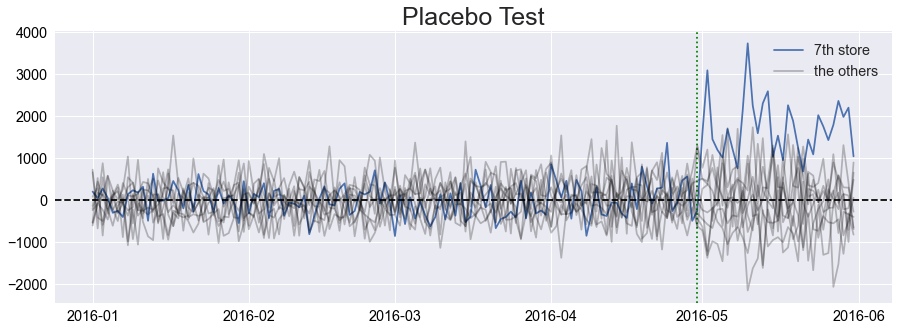

In [38]:
store = 7 
s = SC_effect[str(store)][0]
plt.plot(date, s, label = '7th store')
plt.title('Placebo Test')
plt.axhline(0, color = 'black', linestyle = '--')
plt.axvline(pd.Timestamp('2016-04-30'), color = 'green', linestyle = ':')

for i in range(1,11):
    if i != 7:        
        store = i
        s = SC_effect[str(store)][0]
        c = 'black'
        alpha = 0.25
        
        if i != 9:
            plt.plot(date, s, c = c, alpha = alpha)
        else:
            plt.plot(date, s, c = c, alpha = alpha, label = 'the others')
        
plt.legend()
plt.show()

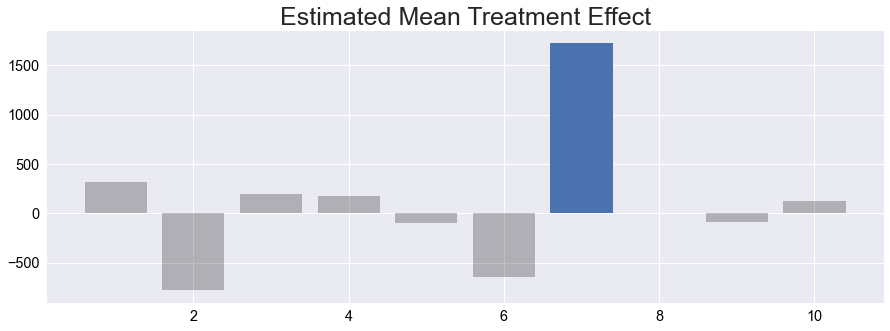

In [35]:
for i in range(1,11):
    target_store = i
    m = SC_effect[str(target_store)][1]
    
    if i == 7:
        c = sns.color_palette()[0]
        alpha = 1
    else:
        c = 'black'
        alpha = 0.25
    
    plt.bar(i, m, color = c, alpha = alpha)

plt.title('Estimated Mean Treatment Effect')
plt.show()

In [36]:
mean_effect = SC_effect[str(7)][1]
error = abs(mean_effect - mu)/sigma

In [37]:
print(f'''The estimated mean treatment effect is {mean_effect}.
The estimate differs from the actual answer by {error} standard deviations.''')

The estimated mean treatment effect is 1723.702004090632.
The estimate differs from the actual answer by 0.1604940406329743 standard deviations.
